In [113]:
import numpy as np
import cv2
import pandas as pd
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans
import itertools 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns


In [85]:
simpson_images = []
labels = [] 
for simpson_dir_path in glob.glob("/Users/hshen/Dropbox/data2/train/*"):
    simpson_label = simpson_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(simpson_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        simpson_images.append(image)
        labels.append(simpson_label)
simpson_images = np.array(simpson_images)
labels = np.array(labels)

In [86]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [87]:
id_to_label_dict

{0: 'homer_simpson', 1: 'lisa_simpson'}

In [88]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(5, 5)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            # axs[i, j].xaxis.set_ticklabels([])
            # axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1        

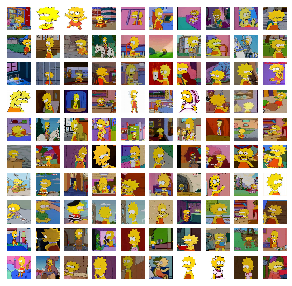

In [89]:
plot_image_grid(simpson_images[0:100], 10, 10)

In [90]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [91]:
scaler = StandardScaler()

In [92]:
images_scaled = scaler.fit_transform([i.flatten() for i in simpson_images])

In [93]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

In [94]:
#Train Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

In [96]:
#Define confusion matrix

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)

In [97]:
test_predictions = forest.predict(X_test)

In [98]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}".format(precision))

Accuracy with RandomForest: 77.222222


In [107]:
auc_test = roc_auc_score(y_test,  test_predictions)
print('AUC Test: %.2f' % auc_test)

AUC Test: 0.73


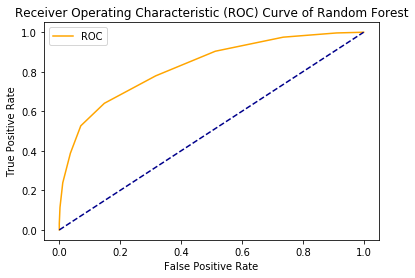

In [108]:
probs=forest.predict_proba(X_test)
preds=probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest')
plt.legend()
plt.show()

In [99]:
cm = confusion_matrix(y_test, test_predictions)

Confusion matrix, without normalization
[[408  31]
 [133 148]]


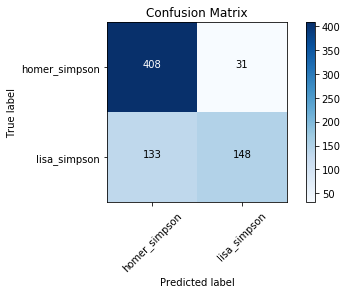

In [100]:
cm_plot_labels = ['homer_simpson', 'lisa_simpson']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [101]:
#train svm
svm_clf = svm.SVC(gamma='auto', kernel='linear', probability=True)
svm_clf = svm_clf.fit(X_train, y_train) 

In [102]:
test_predictions1 = svm_clf.predict(X_test)

In [103]:
precision = accuracy_score(test_predictions1, y_test) * 100
print("Accuracy with SVM: {0:.6f}".format(precision))

Accuracy with SVM: 77.222222


In [109]:
auc_test = roc_auc_score(y_test,  test_predictions1)
print('AUC Test of SVM: %.2f' % auc_test)

AUC Test of SVM: 0.75


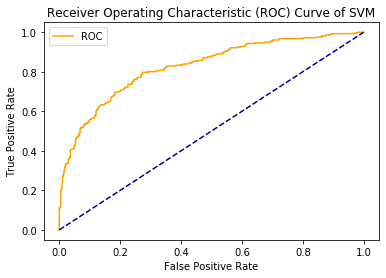

In [110]:
probs=svm_clf.predict_proba(X_test)
preds=probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of SVM')
plt.legend()
plt.show()

In [104]:
cm = confusion_matrix(y_test, test_predictions1)

Confusion matrix, without normalization
[[380  59]
 [105 176]]


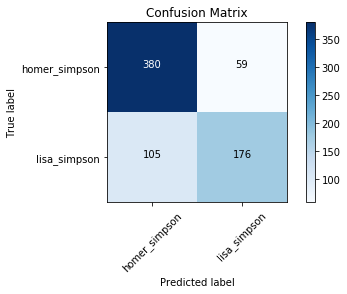

In [105]:
cm_plot_labels = ['homer_simpson', 'lisa_simpson']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

#CNN

In [2]:
train_path = '/Users/hshen/Dropbox/data2/train'
valid_path = '/Users/hshen/Dropbox/data2/val'
test_path = '/Users/hshen/Dropbox/data2/test'

In [3]:
train_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path, target_size=(224,224), classes=['homer_simpson', 'lisa_simpson'], batch_size=500)
valid_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(valid_path, target_size=(224,224), classes=['homer_simpson', 'lisa_simpson'], batch_size=100)
test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, target_size=(224,224), classes=['homer_simpson', 'lisa_simpson'], batch_size=100)

Found 2880 images belonging to 2 classes.
Found 359 images belonging to 2 classes.
Found 361 images belonging to 2 classes.


In [15]:
# plots images with Labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [16]:
sample_training_images, labels = next(train_data_gen)

//anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


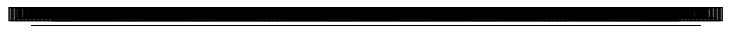

In [17]:
plots(sample_training_images, titles=labels)

In [18]:
# Build and train CNN

In [19]:
total_train=2880
total_val=359
epochs=15

In [22]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
history1 = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train //700,
    epochs=5,
    validation_data=valid_data_gen,
    validation_steps=total_val //100
)

Epoch 1/5
4/4 [==============================] - 37s 9s/step - loss: 0.7097 - accuracy: 0.6150 - val_loss: 0.6741 - val_accuracy: 0.6233
Epoch 2/5
4/4 [==============================] - 33s 8s/step - loss: 0.6748 - accuracy: 0.6091 - val_loss: 0.6702 - val_accuracy: 0.6409
Epoch 3/5
4/4 [==============================] - 36s 9s/step - loss: 0.6639 - accuracy: 0.6360 - val_loss: 0.6525 - val_accuracy: 0.6178
Epoch 4/5
4/4 [==============================] - 34s 9s/step - loss: 0.6570 - accuracy: 0.6149 - val_loss: 0.6518 - val_accuracy: 0.6139
Epoch 5/5
4/4 [==============================] - 35s 9s/step - loss: 0.6425 - accuracy: 0.6271 - val_loss: 0.6494 - val_accuracy: 0.6100


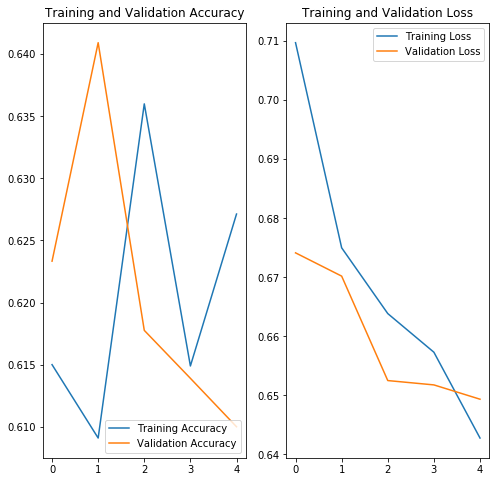

In [25]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
history2 = model1.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train //700,
    epochs=15,
    validation_data=valid_data_gen,
    validation_steps=total_val //100
)

Epoch 1/15
4/4 [==============================] - 36s 9s/step - loss: 3.8326 - accuracy: 0.5888 - val_loss: 1.2958 - val_accuracy: 0.5000
Epoch 2/15
4/4 [==============================] - 34s 9s/step - loss: 1.0330 - accuracy: 0.5027 - val_loss: 0.7247 - val_accuracy: 0.3745
Epoch 3/15
4/4 [==============================] - 35s 9s/step - loss: 0.7115 - accuracy: 0.4775 - val_loss: 0.6882 - val_accuracy: 0.5039
Epoch 4/15
4/4 [==============================] - 36s 9s/step - loss: 0.6851 - accuracy: 0.5750 - val_loss: 0.6152 - val_accuracy: 0.6178
Epoch 5/15
4/4 [==============================] - 35s 9s/step - loss: 0.6583 - accuracy: 0.6250 - val_loss: 0.6341 - val_accuracy: 0.6350
Epoch 6/15
4/4 [==============================] - 34s 8s/step - loss: 0.6270 - accuracy: 0.6314 - val_loss: 0.5825 - val_accuracy: 0.6371
Epoch 7/15
4/4 [==============================] - 35s 9s/step - loss: 0.5818 - accuracy: 0.6685 - val_loss: 0.5799 - val_accuracy: 0.7375
Epoch 8/15
4/4 [==================

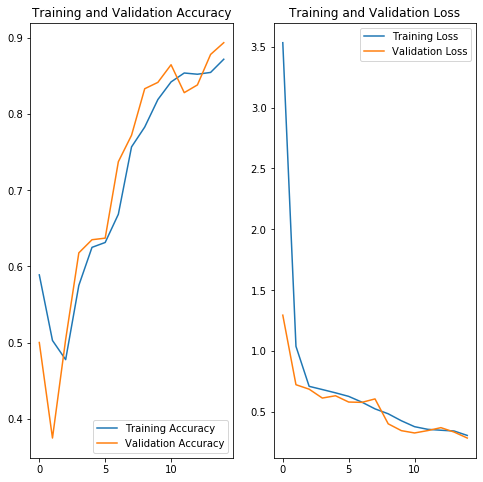

In [28]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
#underfitting

In [30]:
#Visualize training images

In [31]:
sample_training_images, _ = next(train_data_gen)

In [32]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

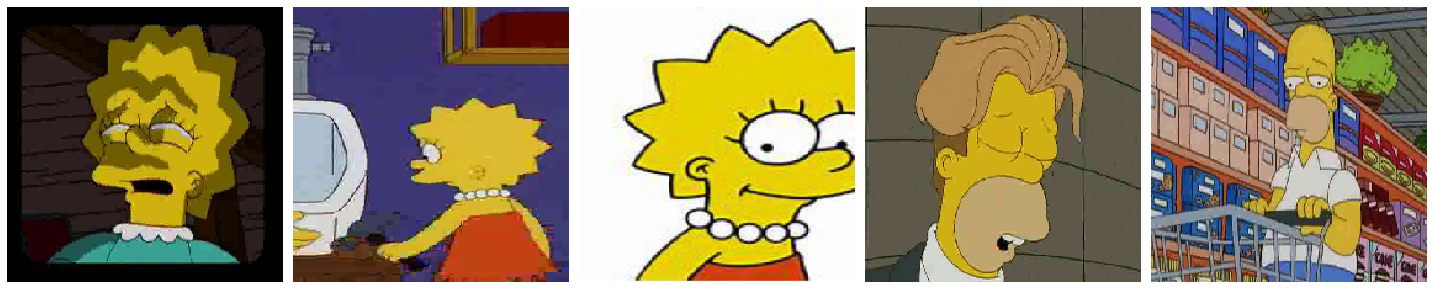

In [33]:
plotImages(sample_training_images[:5])

In [34]:
#Apply horizontal flip

In [35]:
train_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224), classes=['homer_simpson', 'lisa_simpson'], batch_size=500,shuffle=True)
valid_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True).flow_from_directory(valid_path, target_size=(224,224), classes=['homer_simpson', 'lisa_simpson'], batch_size=100,shuffle=True)
test_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes=['homer_simpson', 'lisa_simpson'], batch_size=100,shuffle=True)

Found 2880 images belonging to 2 classes.
Found 359 images belonging to 2 classes.
Found 361 images belonging to 2 classes.


In [36]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

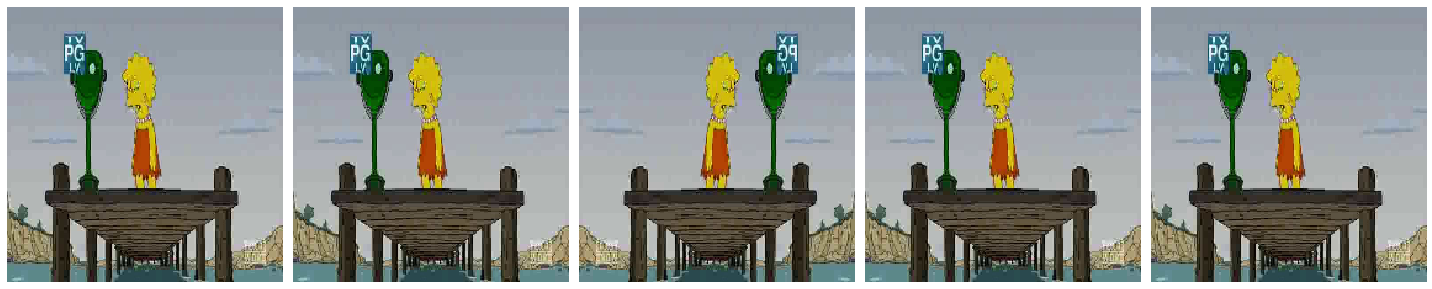

In [37]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

In [38]:
model2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
history3 = model2.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train //700,
    epochs=15,
    validation_data=valid_data_gen,
    validation_steps=total_val //100
)

Epoch 1/15
4/4 [==============================] - 36s 9s/step - loss: 1.6022 - accuracy: 0.5487 - val_loss: 0.7668 - val_accuracy: 0.3767
Epoch 2/15
4/4 [==============================] - 33s 8s/step - loss: 0.7420 - accuracy: 0.4120 - val_loss: 0.6930 - val_accuracy: 0.5135
Epoch 3/15
4/4 [==============================] - 35s 9s/step - loss: 0.6827 - accuracy: 0.5763 - val_loss: 0.6749 - val_accuracy: 0.6100
Epoch 4/15
4/4 [==============================] - 32s 8s/step - loss: 0.6683 - accuracy: 0.6197 - val_loss: 0.6772 - val_accuracy: 0.6332
Epoch 5/15
4/4 [==============================] - 34s 9s/step - loss: 0.6577 - accuracy: 0.6255 - val_loss: 0.6389 - val_accuracy: 0.6500
Epoch 6/15
4/4 [==============================] - 33s 8s/step - loss: 0.6471 - accuracy: 0.6266 - val_loss: 0.6278 - val_accuracy: 0.5830
Epoch 7/15
4/4 [==============================] - 33s 8s/step - loss: 0.6299 - accuracy: 0.6359 - val_loss: 0.5842 - val_accuracy: 0.7066
Epoch 8/15
4/4 [==================

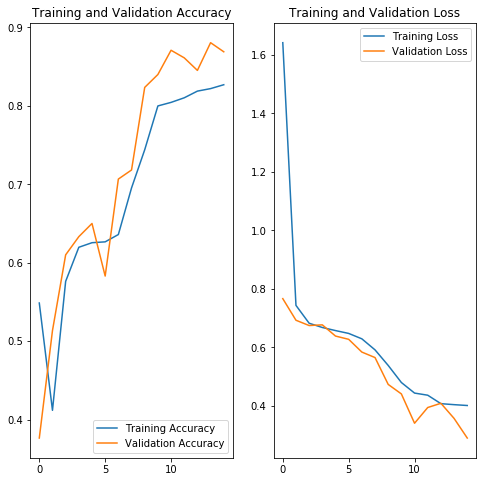

In [40]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Put it all together

In [43]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                    rotation_range=45,
                                    width_shift_range=.15,
                                    height_shift_range=.15,
                                    horizontal_flip=True,
                                    zoom_range=0.5)

In [44]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=700,
                                                    directory=train_path,
                                                    shuffle=True,
                                                    target_size=(224,224),
                                                    )

Found 2880 images belonging to 2 classes.


In [45]:
valid_data_gen=image_gen_train.flow_from_directory(batch_size=700,
                                                    directory=valid_path,
                                                    shuffle=True,
                                                    target_size=(224,224),
                                                    )

Found 359 images belonging to 2 classes.


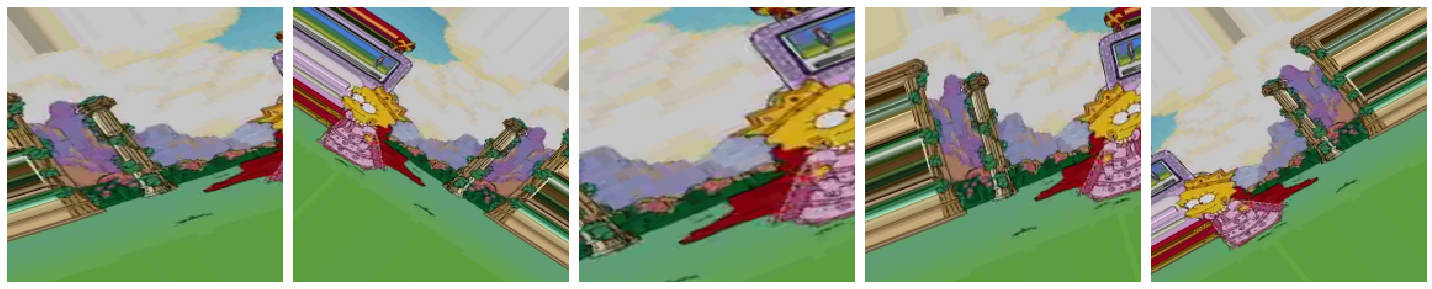

In [46]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [47]:
model3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
history4 = model3.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train //700,
    epochs=15,
    validation_data=valid_data_gen,
    validation_steps=total_val //100
)

Epoch 1/15
4/4 [==============================] - 74s 18s/step - loss: 2.4664 - accuracy: 0.5447 - val_loss: 0.8590 - val_accuracy: 0.3760
Epoch 2/15
4/4 [==============================] - 64s 16s/step - loss: 0.7540 - accuracy: 0.4154 - val_loss: 0.6721 - val_accuracy: 0.6383
Epoch 3/15
4/4 [==============================] - 73s 18s/step - loss: 0.6683 - accuracy: 0.6184 - val_loss: 0.6573 - val_accuracy: 0.6240
Epoch 4/15
4/4 [==============================] - 57s 14s/step - loss: 0.6521 - accuracy: 0.6261 - val_loss: 0.6454 - val_accuracy: 0.6240
Epoch 5/15
4/4 [==============================] - 58s 14s/step - loss: 0.6576 - accuracy: 0.6250 - val_loss: 0.6295 - val_accuracy: 0.6662
Epoch 6/15
4/4 [==============================] - 58s 14s/step - loss: 0.6337 - accuracy: 0.6686 - val_loss: 0.6108 - val_accuracy: 0.6760
Epoch 7/15
4/4 [==============================] - 60s 15s/step - loss: 0.5922 - accuracy: 0.6849 - val_loss: 0.5749 - val_accuracy: 0.7047
Epoch 8/15
4/4 [===========

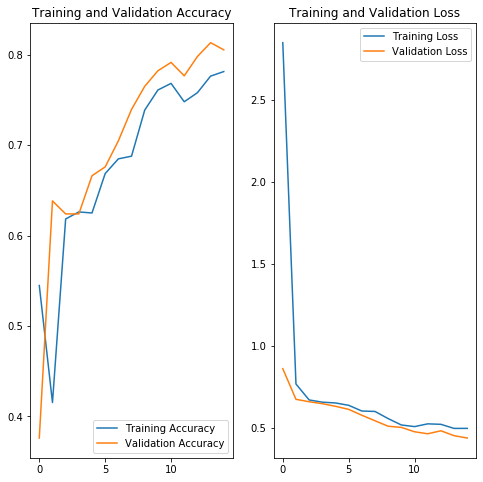

In [49]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Build Fine-tuned VGG16 model

In [4]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 29s 0us/step


In [5]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
type(vgg16_model)

keras.engine.training.Model

In [7]:
model4 = Sequential()
for layer in vgg16_model.layers:
    if layer.name != 'predictions':
        model4.add(layer)

In [8]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [9]:
for layer in model4.layers:
    layer.trainable = False

In [10]:
model4.add(Dense(2, activation='softmax'))

In [11]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [12]:
#Train the fine-tuned VGG16 model

In [13]:
model4.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history=model4.fit_generator(train_data_gen, steps_per_epoch=5,
                   validation_data=valid_data_gen, validation_steps=2, epochs=5, verbose=2)

Epoch 1/5
 - 547s - loss: 0.6805 - accuracy: 0.5849 - val_loss: 0.6583 - val_accuracy: 0.6150
Epoch 2/5
 - 534s - loss: 0.6640 - accuracy: 0.6206 - val_loss: 0.6908 - val_accuracy: 0.6101
Epoch 3/5
 - 645s - loss: 0.6486 - accuracy: 0.6284 - val_loss: 0.6487 - val_accuracy: 0.6300
Epoch 4/5
 - 505s - loss: 0.6334 - accuracy: 0.6471 - val_loss: 0.6131 - val_accuracy: 0.6352
Epoch 5/5
 - 554s - loss: 0.6206 - accuracy: 0.6277 - val_loss: 0.5780 - val_accuracy: 0.6750


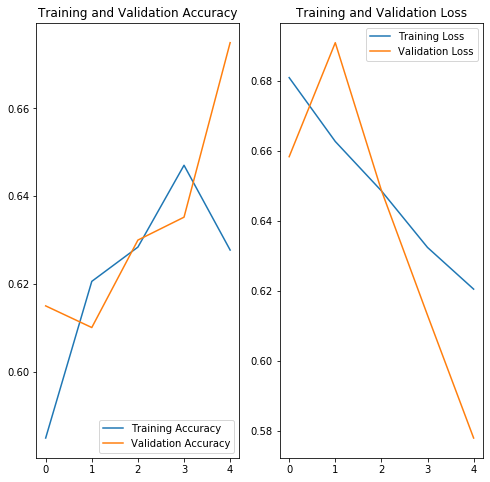

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Predict using fine-tuned VGG16 model by picture

In [117]:
image='/Users/hshen/Dropbox/kaggle_simpson_testset/homer_simpson_2.jpg'

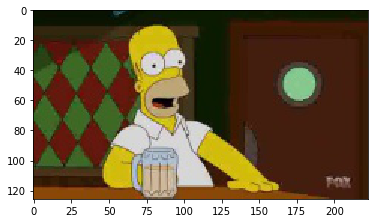

In [118]:
my_image1=plt.imread(image)
img=plt.imshow(my_image1)

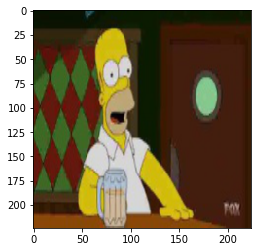

In [119]:
from skimage.transform import resize
my_image_resized1 = resize(my_image1, (224,224,3)) 
img1= plt.imshow(my_image_resized1) 

In [127]:
import numpy as np
probabilities1 = model3.predict(np.array( [my_image_resized1,] ))

In [128]:
probabilities1

array([[0.9114153 , 0.09846259]], dtype=float32)

In [129]:
number_to_class=['homer_simpson','lisa_simpson']

In [130]:
index = np.argsort(probabilities1[0,:])

In [131]:
print("Most likely class:", number_to_class[index[1]], "-- Probability:", probabilities1[0,index[1]])
print("Most likely class:", number_to_class[index[0]], "-- Probability:", probabilities1[0,index[0]])

Most likely class: homer_simpson -- Probability: 0.9114153
Most likely class: lisa_simpson -- Probability: 0.09846259


In [132]:
#To save this model 
model.save('my_model.h5')